### Language Models

Language Models (hereafter, LM(s)) can be considered as black boxes that, given an input, produce non-deterministic outputs, with inputs and outputs both being some element of natural language like syllables, words, phrases, etc. In this project, we present a character-level language model that's a stepping stone to modern LMs.

### Introdution to Trigram Language Model

Trigrams are a special case of n-gram (n=3), where n-gram refers to a sequence of symbols in sequential order. Therefore, an n-gram LM can be considered as an LM that takes in n input characters and gives out 1 output character. Formally, an n-gram LM gives out the probability distribution of all the characters given the previous (n-1)-characters from which one character is sampled out.

A Trigram LM takes in the previous 2 characters as input and gives out a probability distribution of all the characters from which 1 character is sampled out.

### A Brief Overview of the Libraries Used

#### NumPy

NumPy is an open-source library that enables fast and efficient numerical computing in Python. We make use of NumPy to create the probability distribution over our dataset and also to sample from the said distribution.

#### PyTorch

PyTorch is a powerful open-source machine learning library used for the development of deep learning models especially useful for it's automatic differentiation engine. We make use of PyTorch in the second notebook to build the Trigram LM using a Neural Network.

#### Matplotlib

Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. It's widely used to visualize and present data in general. We make use of this open-source library to show probability distribution heatmap, loss visualizations, etc.

#### Seaborn

Seaborn is another visualization library built on top of Matplotlib. It provides high level abstractions over Matplotlib to create attractive statistical graphics.

### Project Structure

We first present the  statistical version of the Trigram LM. In the second notebook, we demonstrate the Trigram LM by modelling the probability distribution table (as shown in the first notebook) using a Neural Network. An empirical observation then follows that both the models are nearly equivalent.

As mentioned before, we also provide sufficient headings and comments documenting our code.

Disclaimer: Every line of code, and documentation is written by us, humans. No content has been directly copy-pasted from an LLM, or any other source, for that matter, except for understanding certain library syntax, and checking factual accuracy.

# Statistical Trigram

## Data Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
words = open("./names.txt", 'r').read().splitlines()

In [3]:
words[:4]

['emma', 'olivia', 'ava', 'isabella']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
two_chars = set()
for c1 in chars+["."]:
  for c2 in chars+["."]:
    two_chars.add(c1+c2)

two_chars = sorted(list(two_chars))

stoi2 = {s:i for i,s in enumerate(two_chars)}
itos2 = {i:s for i,s in enumerate(two_chars)}

## Creating the Probability Distribution Matrix

In [6]:
N = np.zeros((729, 27), dtype=np.float32)
    
# model smoothing
N += 1

# populating matrix with trigram counts
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi2[ch1+ch2]
        ix2 = stoi[ch3]
        N[ix1, ix2] += 1

# creating the probability distribution
P = N
P /= P.sum(1, keepdims=True)

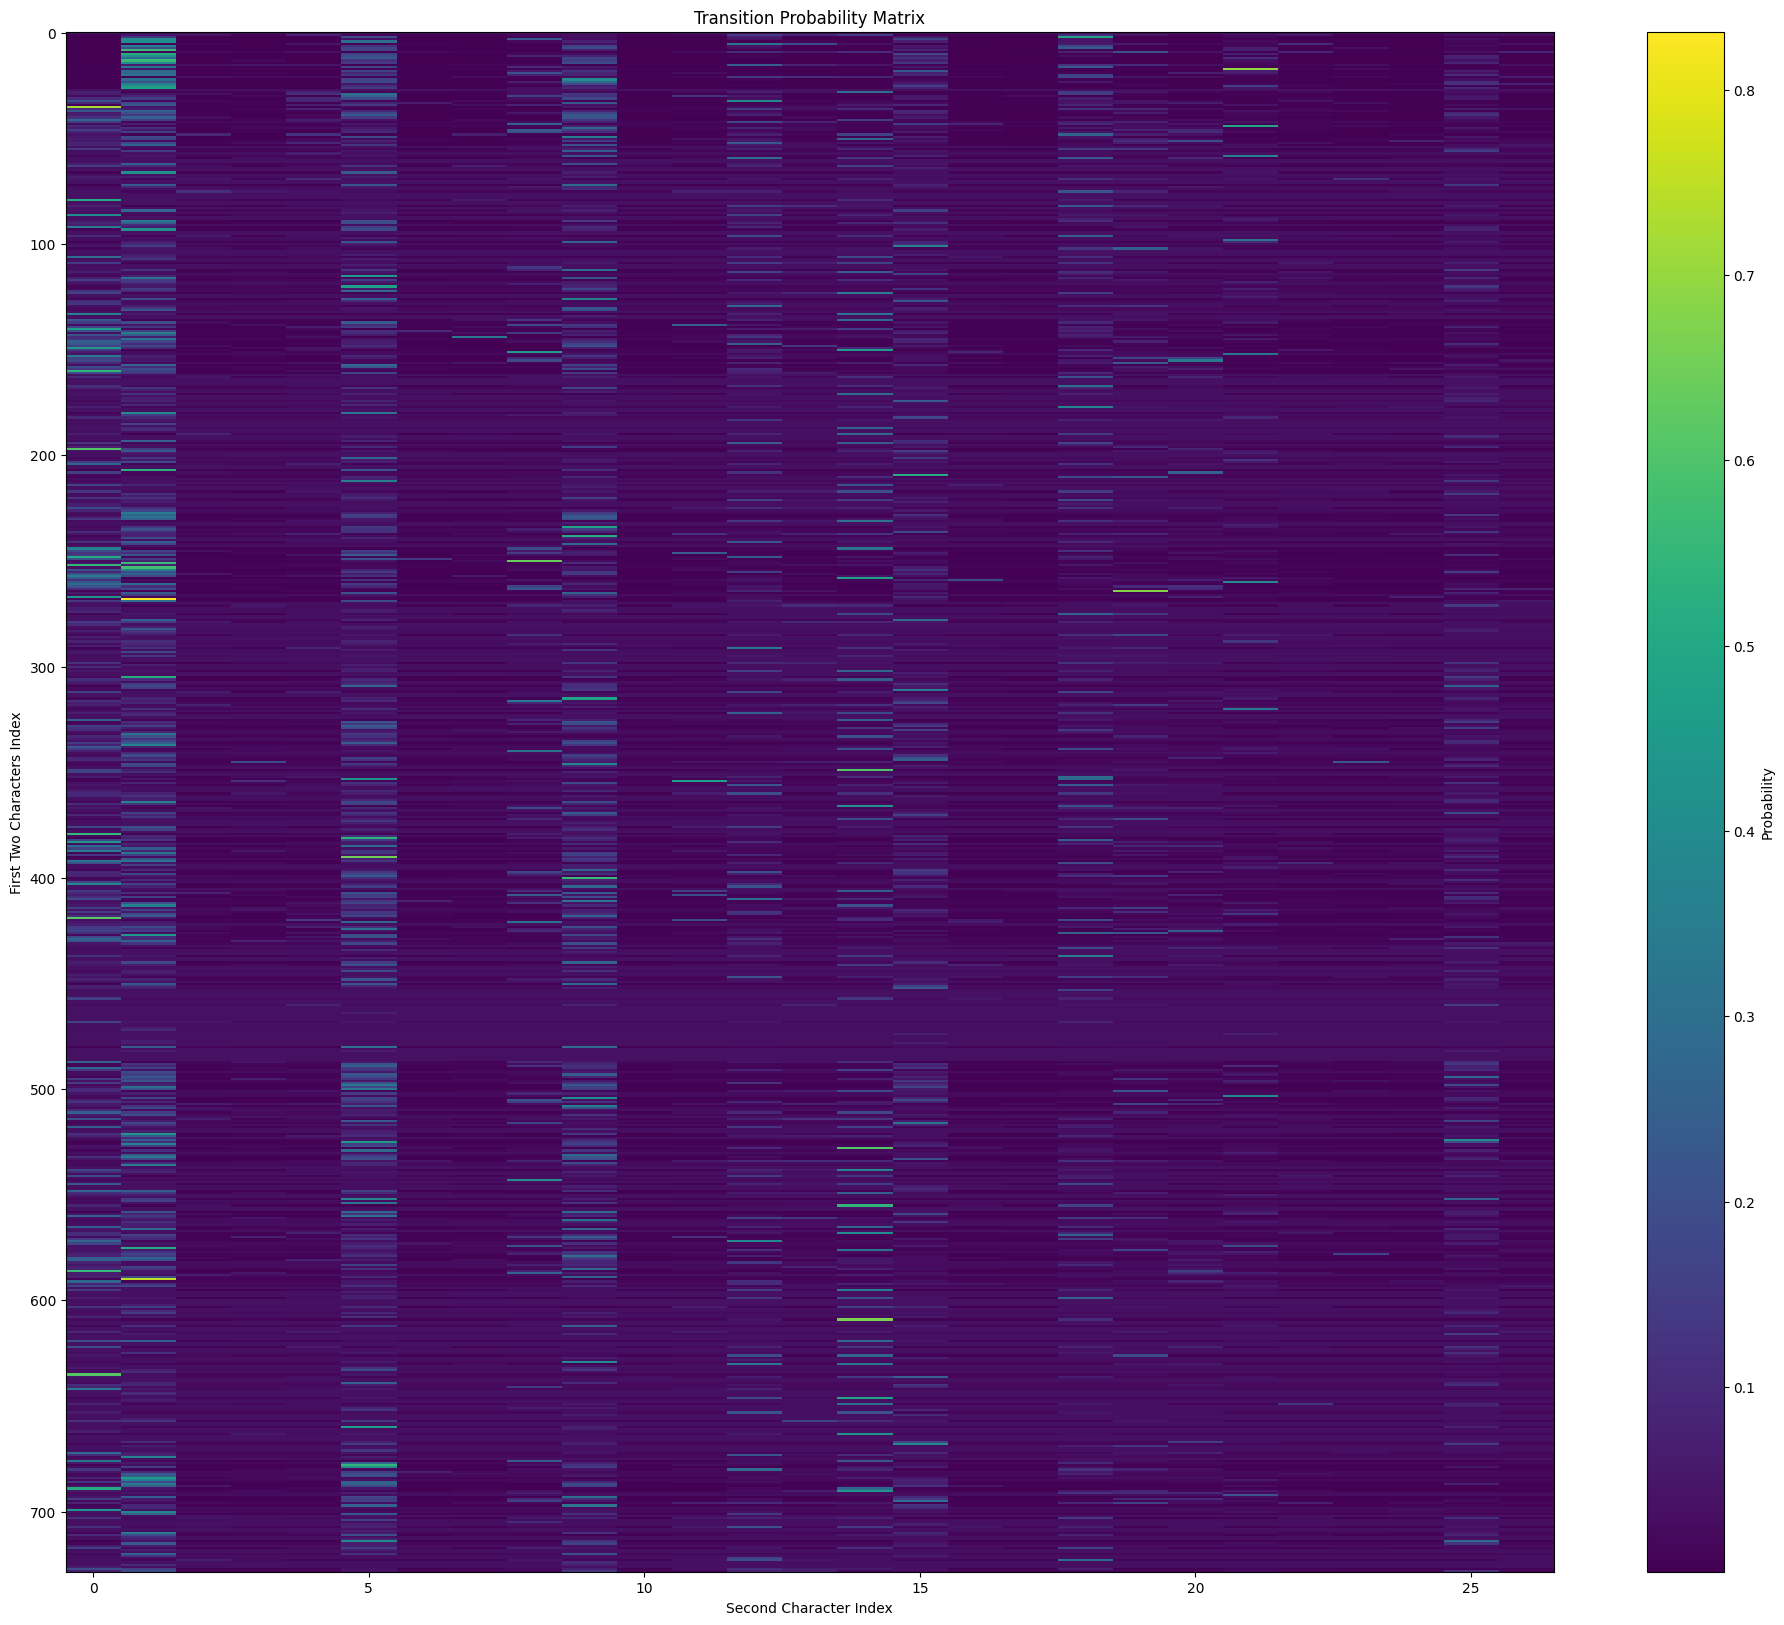

In [7]:
plt.figure(figsize=(24, 20))
plt.imshow(P, cmap='viridis', aspect='auto', interpolation='nearest')

cbar = plt.colorbar()
cbar.set_label('Probability')

plt.xlabel("Second Character Index")
plt.ylabel("First Two Characters Index")
plt.title("Transition Probability Matrix")

plt.show()

## Sampling from the model

In [8]:
g = np.random.default_rng(seed=2147483647)

# sequentially sampling from the probability distribution
for _ in range(10):
    ix = 1
    out = ["."]
    while True:
        if ix != 1:
            ix = stoi2[''.join(out[-2:])]
        p = P[ix]
        ix = g.multinomial(1, p, size=1).argmax()
        out.append(itos[ix])
        if out[-1][-1] == ".":
            break
    
    print(''.join(out))

.reydechadane.
.den.
.valoick.
.esmaus.
.zaroniellyn.
.desaydevarindrekrit.
.muhwftquissadvhtfendshabby.
.brae.
.lah.
.leilaleeven.


## Finding the average NLL with different dataset sizes 

Here we experiment with varying sizes of the dataset to see its correlation with the negative log likelihood. As expected, increasing dataset size gives a better loss.

In [9]:
combs = np.arange(300,30001,300)

In [10]:
avg_nll = {}
for comb in combs:
    N = np.zeros((729, 27), dtype=np.float32)
    
    # model smoothing
    N += 1
    
    for w in words[:comb]:
        chs = ["."] + list(w) + ["."]
        for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi2[ch1+ch2]
            ix2 = stoi[ch3]
            N[ix1, ix2] += 1

    P = N
    P /= P.sum(1, keepdims=True)
    
    n = 0
    log_likelihood = 0.0
    for w in words:
        chs = ["."] + list(w) + ["."]
        for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi2[ch1+ch2]
            ix2 = stoi[ch3]
            prob = P[ix1, ix2]
            logprob = np.log(prob)
            log_likelihood += logprob
            n += 1
    
    nll = -log_likelihood
    avg_nll[comb] = (nll/n)

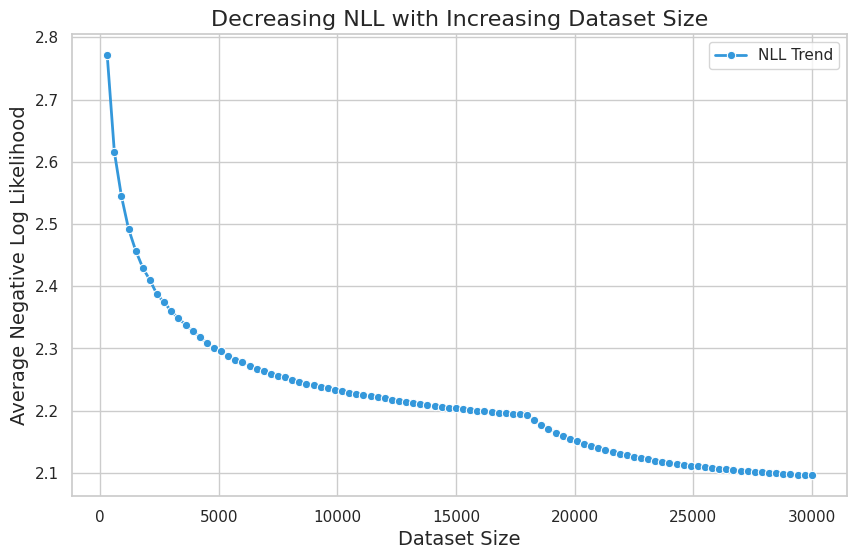

In [11]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x=list(avg_nll.keys()), y=list(avg_nll.values()), marker='o', color='#3498db', linewidth=2, label='NLL Trend')

plt.xlabel("Dataset Size", fontsize=14)
plt.ylabel("Average Negative Log Likelihood", fontsize=14)
plt.title("Decreasing NLL with Increasing Dataset Size", fontsize=16)

plt.legend()
plt.show()

NB: The loss increases at a slightly higher rate after the dataset crosses the size fo 17k.

## Optimal Model Smoothing

We now experiment with different values for the model smoothing factor. We can observe that any value over 1 gives a higher loss.

In [12]:
nums = np.arange(1, 11)
nums

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [13]:
smdl_nll = {}
for num in nums:
    N = np.zeros((729, 27), dtype=np.float32)
    N += num
    for w in words:
        chs = ["."] + list(w) + ["."]
        for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi2[ch1+ch2]
            ix2 = stoi[ch3]
            N[ix1, ix2] += 1
            
    P = N
    P /= P.sum(1, keepdims=True)
    
    n = 0
    log_likelihood = 0.0
    for w in words:
        chs = ["."] + list(w) + ["."]
        for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi2[ch1+ch2]
            ix2 = stoi[ch3]
            prob = P[ix1, ix2]
            logprob = np.log(prob)
            log_likelihood += logprob
            n += 1
    nll = -log_likelihood
    smdl_nll[num] = (nll/n).item()

In [14]:
smdl_nll

{1: 2.0930798649518163,
 2: 2.1157624440037672,
 3: 2.135246232745865,
 4: 2.1526845002373696,
 5: 2.1686244652998914,
 6: 2.1833893669899944,
 7: 2.19719318444803,
 8: 2.210188028218687,
 9: 2.2224874687609204,
 10: 2.234179399642144}

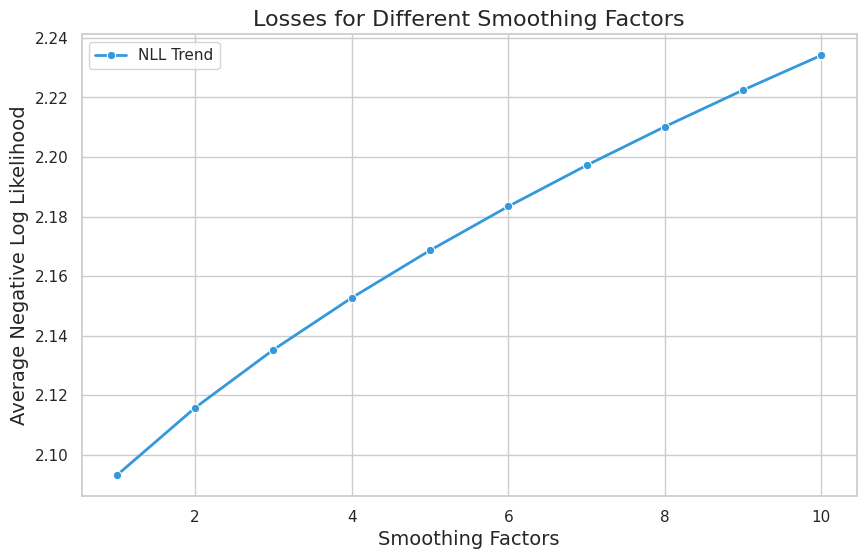

In [15]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.lineplot(x=list(smdl_nll.keys()), y=list(smdl_nll.values()), marker='o', color='#3498db', linewidth=2, label='NLL Trend')

plt.xlabel("Smoothing Factors", fontsize=14)
plt.ylabel("Average Negative Log Likelihood", fontsize=14)
plt.title("Losses for Different Smoothing Factors", fontsize=16)

plt.legend()
plt.show()